In [10]:
import random
import numpy as np


class RoutePlannerMDP:
    def __init__(self, states, actions, transition_probabilities, rewards, gamma=0.9):
        self.states = states
        self.actions = actions
        self.P = transition_probabilities
        self.R = rewards  # rewards is now a dictionary of dictionaries
        self.gamma = gamma
        self.policy = {s: np.random.choice(actions[s]) for s in states}

    def value_iteration(self, theta=1e-6):
        V = {s: 0 for s in self.states}
        while True:
            delta = 0
            for s in self.states:
                v = V[s]
                max_value = float('-inf')
                for a in self.actions[s]:
                    action_value = sum(self.P[s][a][s_next] *
                                       (self.R[s][a] + self.gamma * V[s_next])
                                       for s_next in self.P[s][a])
                    max_value = max(max_value, action_value)
                V[s] = max_value
                delta = max(delta, abs(v - V[s]))
            if delta < theta:
                break

        for s in self.states:
            best_action = None
            best_value = float('-inf')
            for a in self.actions[s]:
                action_value = sum(self.P[s][a][s_next] *
                                   (self.R[s][a] + self.gamma * V[s_next])
                                   for s_next in self.P[s][a])
                if action_value > best_value:
                    best_value = action_value
                    best_action = a
            self.policy[s] = best_action


    def get_optimal_route(self, start_state, max_steps=100):
        route = [start_state]
        current_state = start_state
        steps = 0
        while current_state != "S14" and steps < max_steps:
            action = self.policy[current_state]
            next_states = list(self.P[current_state][action].keys())
            probabilities = list(self.P[current_state][action].values())
            current_state = np.random.choice(next_states, p=probabilities)
            route.append(current_state)
            steps += 1
        if current_state != "S14":
            route.append("Max Steps Exceeded")
        return route

################################################################################################

# Define states and actions
states = [f"S{i}" for i in range(1, 15)]

actions = {
    "S1": ["S2", "S6", "S10"],
    "S2": ["S1", "S6", "S7", "S3", "S11"],
    "S3": ["S2", "S7", "S8", "S4"],
    "S4": ["S3", "S8", "S9", "S5"],
    "S5": ["S4", "S9", "S14"],
    "S6": ["S1", "S2", "S10", "S11", "S7"],
    "S7": ["S2", "S3", "S8", "S12", "S11", "S6"],
    "S8": ["S3", "S4", "S7", "S9", "S12", "S13"],
    "S9": ["S4", "S5", "S8", "S13", "S14"],
    "S10": ["S1", "S6", "S11"],
    "S11": ["S10", "S6", "S2", "S7", "S12"],
    "S12": ["S11", "S7", "S8", "S13"],
    "S13": ["S12", "S8", "S9", "S14"],
    "S14": ["S13", "S9", "S5"]
}

################################################################################################
# Add weather score to states 
################################################################################################

# Weather exposure lookup dictionary
weather_exposure = {
    (1, 2): 95, (1, 6): 1, (1, 10): 1,
    (2, 1): 95, (2, 6): 5, (2, 7): 90, (2, 3): 44, (2, 11): 32,
    (3, 2): 44, (3, 7): 57, (3, 8): 9, (3, 4): 41,
    (4, 3): 41, (4, 8): 54, (4, 9): 50, (4, 5): 65,
    (5, 4): 65, (5, 9): 9, (5, 14): 52,
    (6, 1): 1, (6, 2): 5, (6, 10): 27, (6, 11): 50, (6, 7): 82,
    (7, 2): 90, (7, 3): 57, (7, 8): 51, (7, 12): 33, (7, 11): 27, (7, 6): 82,
    (8, 3): 9, (8, 4): 54, (8, 7): 51, (8, 9): 84, (8, 12): 36, (8, 13): 22,
    (9, 4): 50, (9, 5): 9, (9, 8): 84, (9, 13): 31, (9, 14): 39,
    (10, 1): 1, (10, 6): 27, (10, 11): 52,
    (11, 10): 52, (11, 6): 50, (11, 2): 32, (11, 7): 27, (11, 12): 18,
    (12, 11): 18, (12, 7): 33, (12, 8): 36, (12, 13): 46,
    (13, 12): 46, (13, 8): 22, (13, 9): 31, (13, 14): 80,
    (14, 13): 80, (14, 9): 39, (14, 5): 52
}

# Assign weather exposure scores for each action
weather_scores = {
    state: {action: weather_exposure.get((int(state[1:]), int(action[1:])), 1000)
            for action in neighbors}
    for state, neighbors in actions.items()
}

# O(1) lookup for weather score
# define the state and action to retrieve the weather score
state, action = "S3", "S8"
weather_score = weather_scores[state][action]

################################################################################################
# Add safety score to states
################################################################################################

# Safety exposure lookup dictionary
safety_exposure = {
    (1, 2): 22, (1, 6): 13, (1, 10): 15,
    (2, 1): 22, (2, 6): 19, (2, 7): 36, (2, 3): 41, (2,11): 21,
    (3, 2): 41, (3, 7): 36, (3, 8): 42, (3, 4): 48,
    (4, 3): 48, (4, 8): 42, (4, 9): 62, (4, 5): 66,
    (5, 4): 66, (5, 9): 99, (5, 14): 99,
    (6, 1): 13, (6, 2): 19, (6, 10): 0, (6, 11): 18, (6, 7): 21,
    (7, 2): 36, (7, 3): 36, (7, 8): 38, (7, 12): 39, (7, 11): 18, (7, 6): 21,
    (8, 3): 42, (8, 4): 42, (8, 7): 38, (8, 9): 64, (8, 12): 58, (8, 13): 69,
    (9, 4): 62, (9, 5): 99, (9, 8): 64, (9, 13): 58, (9, 14): 99,
    (10, 1): 15, (10, 6): 0, (10, 11): 1,
    (11, 10): 1, (11, 6): 18, (11, 2): 21, (11, 7): 18, (11, 12): 46,
    (12, 11): 46, (12, 7): 39, (12, 8): 58, (12, 13): 69,
    (13, 12): 69, (13, 8): 69, (13, 9): 58, (13, 14): 99,
    (14, 13): 99, (14, 9): 99, (14, 5): 99
}

# Assign safety scores for each action
safety_scores = {
    state: {action: safety_exposure.get((int(state[1:]), int(action[1:])), 1000)
            for action in neighbors}
    for state, neighbors in actions.items()
}

# O(1) lookup for safety score
# define the state and action to retrieve the safety score
state, action = "S3", "S8"
safety_score = safety_scores[state][action]

################################################################################################
# Add travel time score to states
################################################################################################

# Travel Time lookup dictionary
travel_time = {
    (1, 2): 20, (1, 6): 80, (1, 10): 100,
    (2, 1): 20, (2, 6): 60, (2, 7): 60, (2, 3): 40, (2, 11): 100,
    (3, 2): 40, (3, 7): 60, (3, 8): 60, (3, 4): 20,
    (4, 3): 20, (4, 8): 60, (4, 9): 60, (4, 5): 20,
    (5, 4): 20, (5, 9): 60, (5, 14): 100,
    (6, 1): 80, (6, 2): 60, (6, 10): 60, (6, 11): 40, (6, 7): 20,
    (7, 2): 60, (7, 3): 60, (7, 8): 20, (7, 12): 60, (7, 11): 60, (7, 6): 20,
    (8, 3): 60, (8, 4): 60, (8, 7): 20, (8, 9): 20, (8, 12): 60, (8, 13): 40,
    (9, 4): 60, (9, 5): 60, (9, 8): 20, (9, 13): 60, (9, 14): 60,
    (10, 1): 100, (10, 6): 60, (10, 11): 20,
    (11, 10): 20, (11, 6): 40, (11, 2): 100, (11, 7): 60, (11, 12): 20,
    (12, 11): 20, (12, 7): 60, (12, 8): 60, (12, 13): 20,
    (13, 12): 20, (13, 8): 40, (13, 9): 60, (13, 14): 20,
    (14, 13): 20, (14, 9): 60, (14, 5): 100
}

# Assign travel time scores for each action
travel_time_scores = {
    state: {action: travel_time.get((int(state[1:]), int(action[1:])), 1000)
            for action in neighbors}
    for state, neighbors in actions.items()
}

# O(1) lookup for travel time score
# define the state and action to retrieve the travel time score
state, action = "S3", "S8"
travel_time_score = travel_time_scores[state][action]


################################################################################################
# Function to dynamically calculate the reward based on the state and action, using the scores
################################################################################################

# Define the normalization ranges (assuming max and min possible values for each score type)
WEATHER_MAX = 1000
SAFETY_MAX = 1000
TRAVEL_TIME_MAX = 1000

# Define the weights for each score (adjust based on their importance)
WEATHER_WEIGHT = 0.3
SAFETY_WEIGHT = 0.4
TRAVEL_TIME_WEIGHT = 0.3


def normalize_score(score, max_score):
    """ Normalize the score based on the maximum score for each category. """
    return score / max_score


def calculate_reward(state, action):
    """ 
    Smarter reward function that considers normalized scores and weighted importance. 
    Incorporates dynamic scaling for weather, safety, and travel time.
    """

    # Retrieve individual scores
    weather_score = weather_scores[state][action]
    safety_score = safety_scores[state][action]
    travel_time_score = travel_time_scores[state][action]

    # Normalize the scores to be between 0 and 1
    normalized_weather = normalize_score(weather_score, WEATHER_MAX)
    normalized_safety = normalize_score(safety_score, SAFETY_MAX)
    normalized_travel_time = normalize_score(
        travel_time_score, TRAVEL_TIME_MAX)

    # Calculate weighted sum of normalized scores
    total_score = (WEATHER_WEIGHT * normalized_weather +
                   SAFETY_WEIGHT * normalized_safety +
                   TRAVEL_TIME_WEIGHT * normalized_travel_time)

    # Reward is the negative of the total score (since higher scores should be worse)
    reward = -1 * total_score

    return reward


# Example usage: calculate reward for state "S3" and action "S8"
state, action = "S3", "S8"
reward = calculate_reward(state, action)
print(f"Reward for state {state} and action {action}: {reward}")

################################################################################################
# Fill up the Rewards dictionary
################################################################################################

# Fill up the Rewards dictionary to make sure it's a dictionary of dictionaries
rewards = {
    state: {action: calculate_reward(state, action) for action in neighbors}
    for state, neighbors in actions.items()
}


# # Print the rewards table in a readable format
# print("Rewards Table:")
# print(
#     "State -> [Action1, Action2, ..., ActionN] -> [Reward1, Reward2, ..., RewardN]")

# for state, neighbors in actions.items():
#     rewards_for_state = rewards[state]
#     print(f"{state} -> {neighbors} -> {rewards_for_state}")

################################################################################################
# Implement transition probabilities
################################################################################################

# Define the transition probabilities for each state-action pair
def generate_transition_probability(state, action, states):
    # Assuming a random probability for demonstration (this can be customized)
    prob_sum = 0
    transition_probabilities = {}

    # Assigning random probabilities to all possible transitions
    for next_state in states:
        if next_state != state:
            # Generate a random probability between 0 and 1
            prob = random.uniform(0, 1)
            transition_probabilities[next_state] = prob
            prob_sum += prob

    # Normalize probabilities to ensure they sum up to 1
    for next_state in transition_probabilities:
        transition_probabilities[next_state] /= prob_sum

    return transition_probabilities


# Create transition probabilities for each state-action pair
transition_probabilities = {
    state: {
        action: generate_transition_probability(state, action, actions.keys())
        for action in neighbors
    }
    for state, neighbors in actions.items()
}
        
################################################################################################
# Implement transition probabilities
################################################################################################

# Initialize and solve the MDP
route_planner = RoutePlannerMDP(
    states, actions, transition_probabilities, rewards)
route_planner.value_iteration()

# Find optimal route from S1
optimal_route = route_planner.get_optimal_route("S1")
print("Optimal Route:", optimal_route)

Reward for state S3 and action S8: -0.037500000000000006
Optimal Route: ['S1', np.str_('S5'), np.str_('S9'), np.str_('S13'), np.str_('S4'), np.str_('S2'), np.str_('S13'), np.str_('S12'), np.str_('S4'), np.str_('S5'), np.str_('S1'), np.str_('S5'), np.str_('S11'), np.str_('S3'), np.str_('S14')]


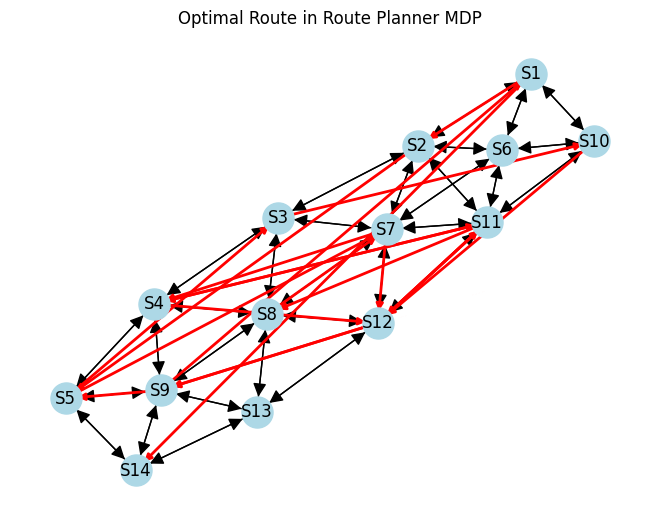

In [6]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

# Add edges for all possible actions
for state in actions:
    for action in actions[state]:
        G.add_edge(state, action)

# Draw basic network
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue',
        node_size=500, arrowsize=20)

# Highlight the optimal route
path_edges = list(zip(optimal_route, optimal_route[1:]))
nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='r', width=2)

plt.title("Optimal Route in Route Planner MDP")
plt.show()

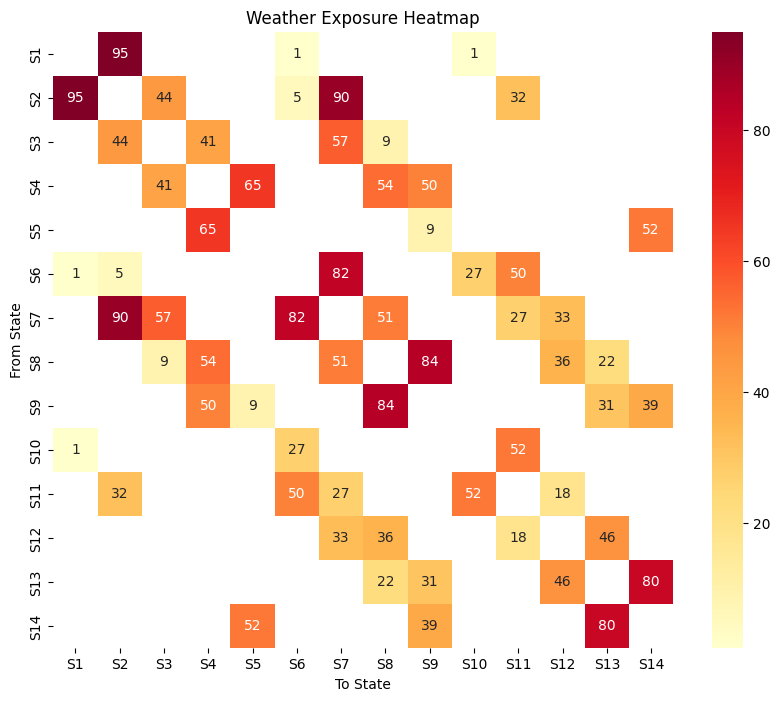

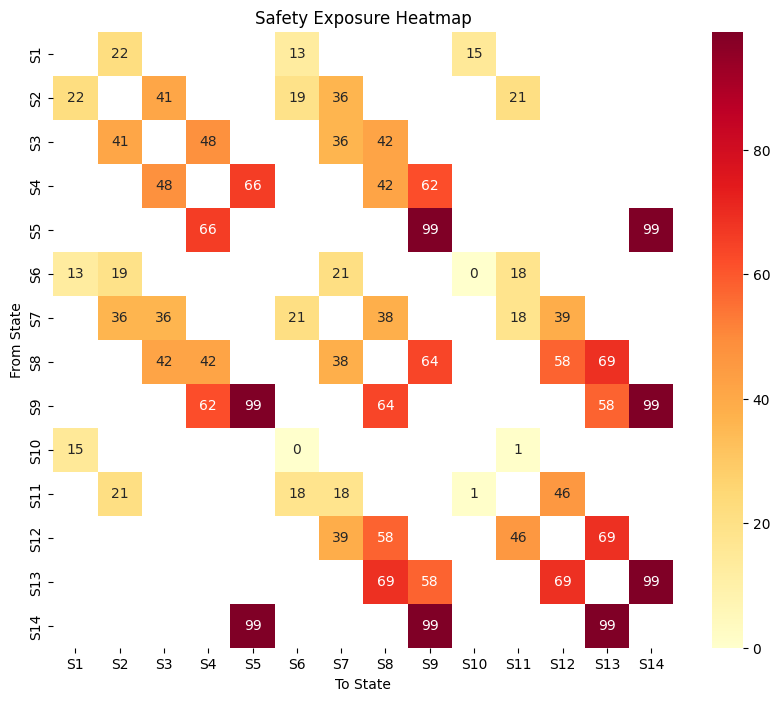

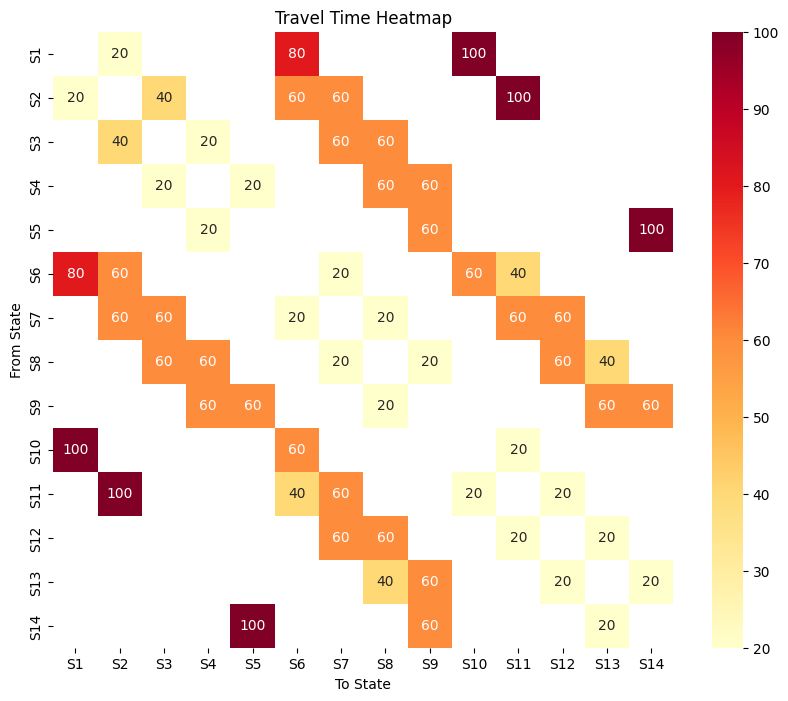

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


def create_heatmap(score_dict, title):
    # Create an empty 14x14 matrix
    matrix = np.full((14, 14), np.nan)

    for state in states:
        i = int(state[1:]) - 1
        for action in actions[state]:
            j = int(action[1:]) - 1
            matrix[i, j] = score_dict[state][action]

    # Convert to DataFrame for seaborn
    df = pd.DataFrame(matrix, index=states, columns=states)

    plt.figure(figsize=(10, 8))
    sns.heatmap(df, annot=True, cmap="YlOrRd", fmt=".0f", cbar=True)
    plt.title(title)
    plt.xlabel("To State")
    plt.ylabel("From State")
    plt.show()


# Create heatmaps for each reward dimension
create_heatmap(weather_scores, "Weather Exposure Heatmap")
create_heatmap(safety_scores, "Safety Exposure Heatmap")
create_heatmap(travel_time_scores, "Travel Time Heatmap")

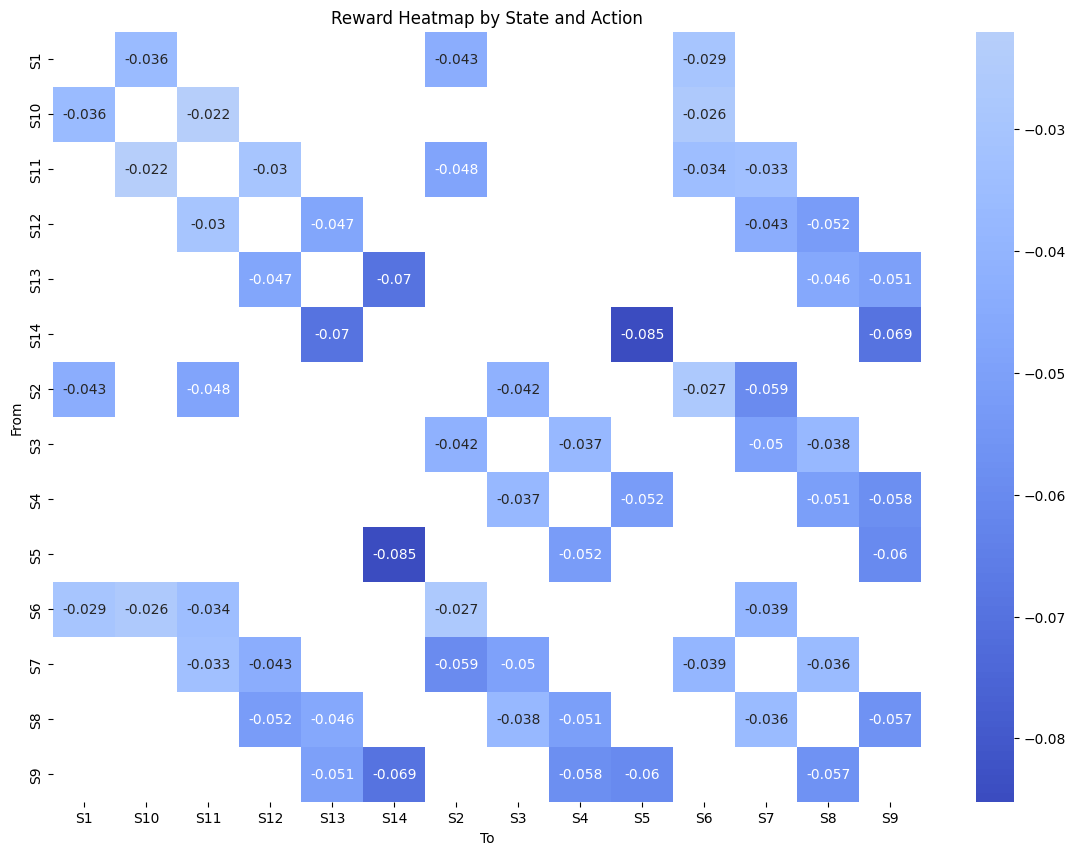

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Convert rewards dict to a flat list of (From, To, Reward)
reward_data = [(state, action, reward)
               for state, actions_dict in rewards.items()
               for action, reward in actions_dict.items()]

# Create DataFrame
df_rewards = pd.DataFrame(reward_data, columns=["From", "To", "Reward"])

# Pivot table for heatmap
reward_matrix = df_rewards.pivot(index="From", columns="To", values="Reward")

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(reward_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Reward Heatmap by State and Action")
plt.show()